# Snowflake Warehouse Reports Using Snowflake Snowpark

<blockquote>
    Calling Configuration Notebook at #1
    <br>Establishing Connection To Snowflake 
    <br>Generating Warehouse Cost Matrix From Snowflake
    <br>Sending an Customized Alert
</blockquote>

In [21]:
# Importing Libraries for notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.ticker as ticker


In [9]:
#Calling Config notebook for Defining Snowpark Connection
%run ./sf_config.ipynb

In [10]:
#Establishing the snowflake snowpark connection
conn = Session.builder.configs(conn_config).create()

In [11]:
#Using Snowpark Session SQL To Query Warehouse Credits Consumption in last 30 Days

sp_warehouse_consumption = conn.sql("WITH CTE_DATE_WH AS(  \
  SELECT TO_DATE(START_TIME) AS START_DATE \
        ,WAREHOUSE_NAME \
        ,SUM(CREDITS_USED) AS CREDITS_USED_DATE_WH \
    FROM SNOWFLAKE.ACCOUNT_USAGE.WAREHOUSE_METERING_HISTORY \
   GROUP BY START_DATE \
           ,WAREHOUSE_NAME \
) \
SELECT START_DATE \
      ,WAREHOUSE_NAME \
      ,round(CREDITS_USED_DATE_WH) AS CREDITS_USED_DATE_WH \
  FROM CTE_DATE_WH \
where CREDITS_USED_DATE_WH > 0  \
AND START_DATE > DATEADD(Month,-1,CURRENT_TIMESTAMP())")
sp_warehouse_consumption = conn.sql('select * from db_roles.public.wh_logs')
pd_warehouse_consumption = sp_warehouse_consumption.to_pandas()



In [15]:
sp_user_consumption = conn.sql("""WITH USER_HOUR_EXECUTION_CTE AS (
    SELECT  USER_NAME
    ,WAREHOUSE_NAME
    ,DATE_TRUNC('hour',START_TIME) as START_TIME_HOUR
    ,SUM(EXECUTION_TIME)  as USER_HOUR_EXECUTION_TIME
    FROM "SNOWFLAKE"."ACCOUNT_USAGE"."QUERY_HISTORY" 
    WHERE WAREHOUSE_NAME IS NOT NULL
    AND EXECUTION_TIME > 0
    AND START_TIME > DATEADD(Month,-1,CURRENT_TIMESTAMP())
    group by 1,2,3
    )
, HOUR_EXECUTION_CTE AS (
    SELECT  START_TIME_HOUR
    ,WAREHOUSE_NAME
    ,SUM(USER_HOUR_EXECUTION_TIME) AS HOUR_EXECUTION_TIME
    FROM USER_HOUR_EXECUTION_CTE
    group by 1,2
)
, APPROXIMATE_CREDITS AS (
    SELECT 
    A.USER_NAME
    ,C.WAREHOUSE_NAME
    ,(A.USER_HOUR_EXECUTION_TIME/B.HOUR_EXECUTION_TIME)*C.CREDITS_USED AS APPROXIMATE_CREDITS_USED

    FROM USER_HOUR_EXECUTION_CTE A
    JOIN HOUR_EXECUTION_CTE B  ON A.START_TIME_HOUR = B.START_TIME_HOUR and B.WAREHOUSE_NAME = A.WAREHOUSE_NAME
    JOIN "SNOWFLAKE"."ACCOUNT_USAGE"."WAREHOUSE_METERING_HISTORY" C ON C.WAREHOUSE_NAME = A.WAREHOUSE_NAME AND C.START_TIME = A.START_TIME_HOUR
)

SELECT 
 USER_NAME
,WAREHOUSE_NAME
,SUM(APPROXIMATE_CREDITS_USED) AS APPROXIMATE_CREDITS_USED
FROM APPROXIMATE_CREDITS
GROUP BY 1,2
ORDER BY 3 DESC;""")
pd_user_consumption = sp_user_consumption.to_pandas()
pd_user_consumption

,USER_NAME,WAREHOUSE_NAME,APPROXIMATE_CREDITS_USED
0,DIVYANSH,COMPUTE_WH,9.136756391000
1,DIVYANSH,ETL_LOAD_WH,4.847304723000
2,DIVYANSH,SNOWPARK_ML_WH,2.101813612000


In [20]:
sp_queries_exec_time = conn.sql("""SELECT 
substr(QUERY_TEXT,0,25) as partial_query_text
,count(*) as number_of_queries
,sum(TOTAL_ELAPSED_TIME)/1000 as execution_seconds
,sum(TOTAL_ELAPSED_TIME)/(1000*60) as execution_minutes
,sum(TOTAL_ELAPSED_TIME)/(1000*60*60) as execution_hours

  from SNOWFLAKE.ACCOUNT_USAGE.QUERY_HISTORY Q
  where 1=1
  and TO_DATE(Q.START_TIME) >     DATEADD(month,-1,TO_DATE(CURRENT_TIMESTAMP())) 
 and TOTAL_ELAPSED_TIME > 0 --only get queries that actually used compute
  group by 1
  having count(*) >= 10 --configurable/minimal threshold
  order by 2 desc
  limit 20 --configurable upper bound threshold
  ;""")

pd_queries_exec_time = sp_queries_exec_time.to_pandas()
pd_queries_exec_time

,PARTIAL_QUERY_TEXT,NUMBER_OF_QUERIES,EXECUTION_SECONDS,EXECUTION_MINUTES,EXECUTION_HOURS
0,show WAREHOUSES like 'COM,59,3.675000,0.061250,0.001021
1,SELECT CURRENT_AVAILABLE_,43,2.459000,0.040983,0.000683
2,"SELECT ""CS_ORDER_NUMBER"",",40,5.881000,0.098017,0.001634
3,show ROLES,40,2.089000,0.034817,0.000580
4,show grants on SCHEMA IDE,39,2.161000,0.036017,0.000600
5,"DESC USER IDENTIFIER('""DI",35,1.628000,0.027133,0.000452
6,show WAREHOUSES,32,1.930000,0.032167,0.000536
7,GET '@~/worksheet_data/me,31,1.953000,0.032550,0.000543
8,SELECT * FROM ( SELECT,28,15.247000,0.254117,0.004235
9,SHOW DATA EXCHANGES;,27,2.047000,0.034117,0.000569


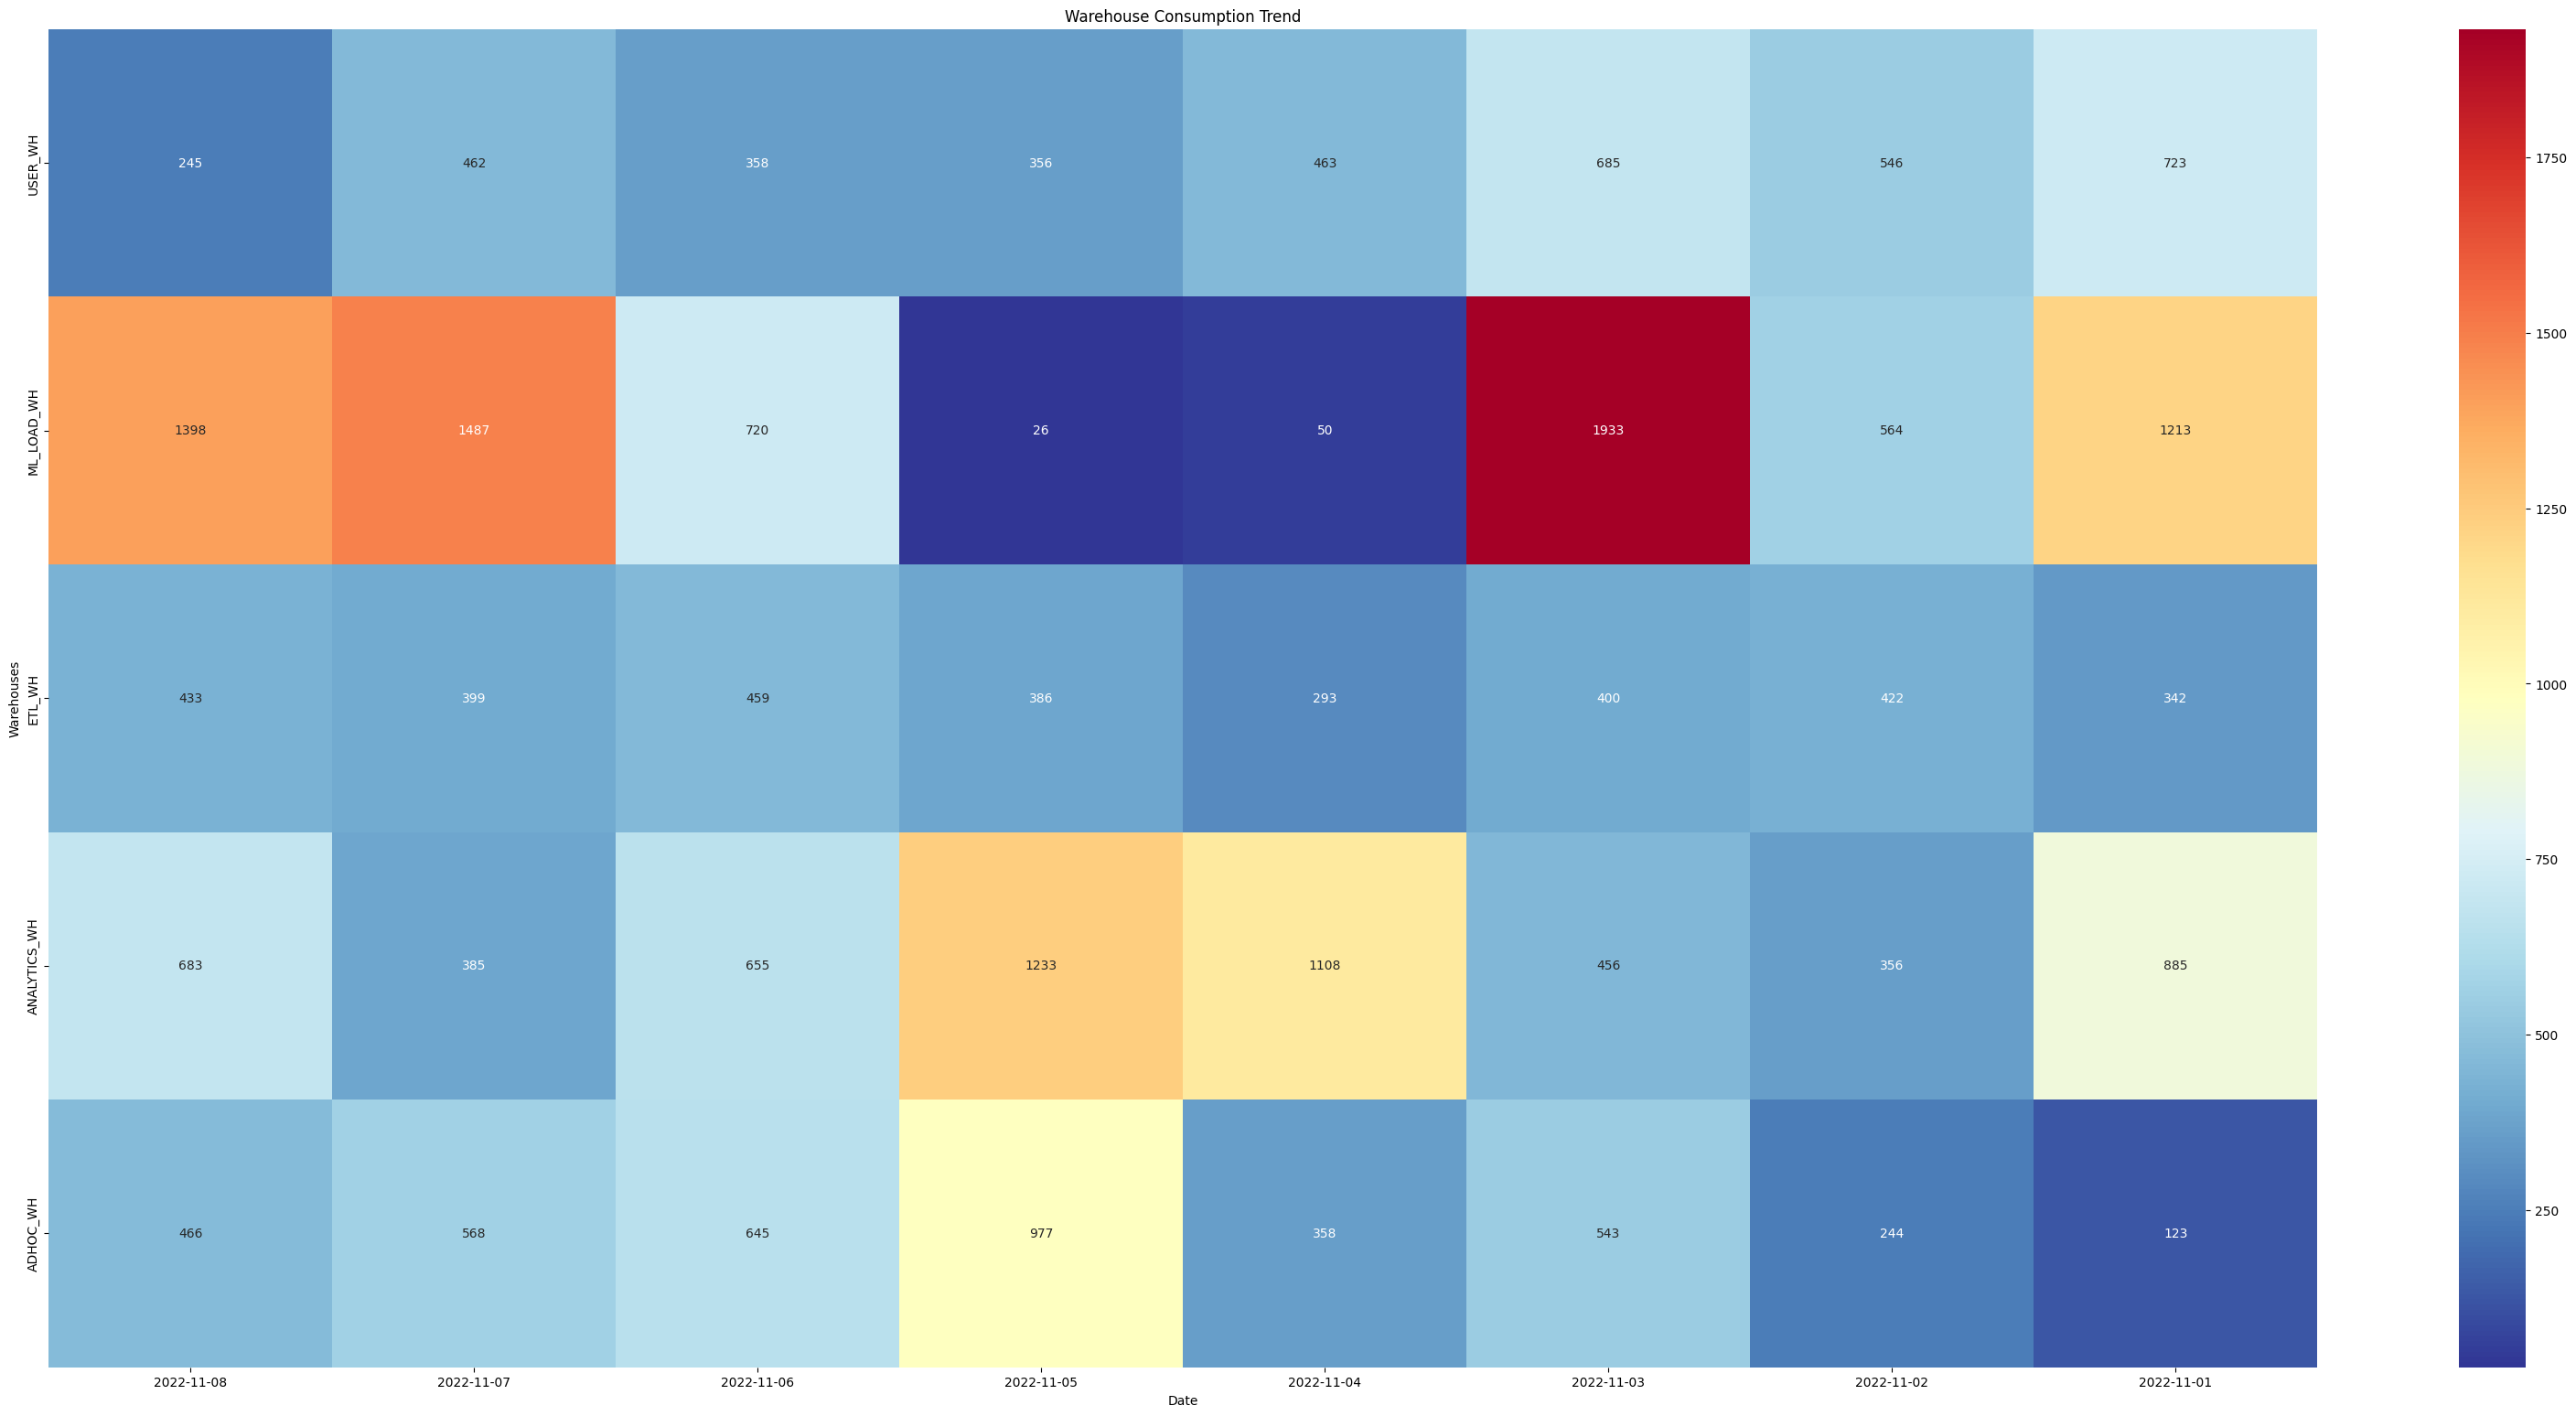

In [5]:
df_pivot = pd.pivot_table(pd_warehouse_consumption
                          ,values='CREDITS_USED_DATE_WH'
                          ,index='WAREHOUSE_NAME'
                          ,columns='START_DATE')
df_pivot
plt.figure(figsize=(40,19))
plt.title('Warehouse Consumption Trend')
a = sns.heatmap(df_pivot,annot=True,cmap='RdYlBu_r',fmt='.4g',)
a.invert_xaxis()
a.invert_yaxis()
plt.xlabel('Date')
plt.ylabel('Warehouses')
plt.show()
a.figure.savefig('img.jpg',bbox_inches = 'tight')


In [70]:
#creating HTML Template for Email Alert

path1 = "img.jpg"

template_css_header = """
<html>
   <head>
         <style>
            table {
               border-collapse: collapse;
            }
            th, td {
               border: 1px solid black;
               padding: 5px;
               text-align: left;
            }
      </style>
   </head>
"""

template_end_footer = """
      </table>
      <br>
      <br>
      <hr/>
   </body>
</html>
"""

template_warehouse_usage = """
   <body>
      <H3>Snowpark Generated Snowflake Utilization Report</H3>
      <hr>
      <IMG height=auto width=100% SRC = 'cid:{current_dupe_graph}' ></img>
      <br>
      <br>
""".format(current_dupe_graph = path1 )


template = template_css_header +template_warehouse_usage + template_end_footer



In [23]:
#Calling Config notebook for Defining Snowpark Connection
%run ./mail_config.ipynb

In [71]:
mail_subject = "Snowflake Utility Report"
to_list = "divyanshsaxenaofficial@gmail.com"
cc_list = "divyanshsaxenaofficial@gmail.com"
sender = "divyanshsaxenaofficial@gmail.com"
msg = email.message.EmailMessage()
msg = MIMEMultipart()
msg["To"] = to_list
msg["Cc"] = cc_list
msg["From"] = sender
msg["Subject"] = mail_subject
body = template
msgText = MIMEText(body, 'html')  
msg.attach(msgText)

#EMBEDDING THE PNG GRAPH IMAGES IN EMAIL
#**********************************************************************************************

with open(path1, 'rb') as fp:
    img = MIMEImage(fp.read())
img.add_header('Content-ID', '<{}>'.format(path1))
msg.attach(img)


#**********************************************************************************************

server = smtplib.SMTP('smtp.gmail.com', 587)
server.starttls()
server.SentOnBehalfOfName = sender_onBehalf
server.login(login_mail, login_credential)
server.send_message(msg)
server.quit()

(221,
 b'2.0.0 closing connection q23-20020a62ae17000000b006254367756bsm4747250pff.108 - gsmtp')